In [54]:
import datetime
import configparser
import os

import numpy as np
import pandas as pd

In [2]:
DEGREE = 3
CONFIG_NAME = 'comb'
MESH_NAME = 'finest'
MODEL_NAME = '1SM'
K = 9
ROMBERG_K = 5
GROUNDED_PLATE_AT = -0.088

FILENAME_PATTERN = f'FEM/solutions/paper/{MODEL_NAME}/{MESH_NAME}_{DEGREE}/{CONFIG_NAME}_sampled/{K}/{{name}}.npz'
ES_PREFIX = f'ES/paper_{MODEL_NAME}__{MESH_NAME}_{DEGREE}_{CONFIG_NAME}'

In [3]:
ELECTRODES = []
for col, x in zip('ABCDE', np.linspace(-6e-3, 6e-3, 5)):
    for row, z in enumerate(np.linspace(0.046, 0.076, 13)):
        ELECTRODES.append({'NAME': f'{col}_{row:02d}',
                           'X': x,
                           'Y': 0.0,
                           'Z': z})
ELECTRODES = pd.DataFrame(ELECTRODES)

In [6]:
import _fast_reciprocal_reconstructor as frr
import _common_new as common

from _dicom import crude_plot_data

In [7]:
class Electrode_kESI(object):
    def __init__(self, filename, decimals_tolerance=None, dx=0):
        self.filename = filename
        self.decimals_tolerance = decimals_tolerance
        self.dx = dx
        with np.load(filename) as fh:
            self._X = self.round(fh['X'])
            self._Y = self.round(fh['Y'])
            self._Z = self.round(fh['Z'])
            self.x, self.y, self.z = fh['LOCATION']
#             try:
            self.base_conductivity = fh['BASE_CONDUCTIVITY']
#             except KeyError:
#                 pass
    
    def round(self, A):
        if self.decimals_tolerance is None:
            return A
        return np.round(A, decimals=self.decimals_tolerance)

    def correction_potential(self, X, Y, Z):
        _X, IDX_X, _ = np.intersect1d(self._X, self.round(X[:, 0, 0]), return_indices=True)
        assert len(_X) == np.shape(X)[0]
        _Y, IDX_Y, _ = np.intersect1d(self._Y, self.round(Y[0, :, 0]), return_indices=True)
        assert len(_Y) == np.shape(Y)[1]
        _Z, IDX_Z, _ = np.intersect1d(self._Z, self.round(Z[0, 0, :]), return_indices=True)
        assert len(_Z) == np.shape(Z)[2]

        with np.load(self.filename) as fh:
            return fh['CORRECTION_POTENTIAL'][np.ix_(IDX_X, IDX_Y, IDX_Z)]

    def base_potential(self, X, Y, Z):
        return (0.25 / (np.pi * self.base_conductivity)
                / (self.dx * 0.15
                   + np.sqrt(np.square(X - self.x)
                             + np.square(Y - self.y)
                             + np.square(Z - self.z))))

        
class Electrode_kCSD(object):
    def __init__(self, filename):
        with np.load(filename) as fh:
            self.x, self.y, self.z = fh['LOCATION']

In [8]:
electrode = Electrode_kESI(FILENAME_PATTERN.format(name='A_00'))
# assert all(X == electrode._X)
# assert all(Y == electrode._Y)
# assert all(Z == electrode._Z)
XX = electrode._X
YY = electrode._Y
ZZ = electrode._Z

In [10]:
dx = (XX[-1] - XX[0]) / (len(XX) - 1)
SRC_R_MAX = (2**(ROMBERG_K - 1)) * dx
ROMBERG_N = 2**ROMBERG_K + 1
print(SRC_R_MAX)

NAIVE_R_MAX = 90e-3 - SRC_R_MAX
NAIVE_R_MIN = 31e-3

INFORMED_R_MAX = 79e-3
INFORMED_R_MIN = 67e-3

E_Z_MAX = 76.1e-3
E_Z_MIN = 39.9e-3
E_X_DIST_MAX = 6.0001e-3


X_DIST_MAX = 9e-3
Y_DIST_MAX = 1e-3
print(E_Z_MIN, E_Z_MAX)

0.005625
0.0399 0.0761


In [11]:
X = XX[abs(XX) < X_DIST_MAX + SRC_R_MAX + dx]
Y = YY[abs(YY) < Y_DIST_MAX + SRC_R_MAX + dx]
Z = ZZ[(ZZ < max(NAIVE_R_MAX, INFORMED_R_MAX) + SRC_R_MAX + dx)
      & (ZZ > min(NAIVE_R_MIN, INFORMED_R_MIN) - SRC_R_MAX - dx)]

In [12]:
ELE_NAIVE = ELECTRODES[(ELECTRODES.Z >= E_Z_MIN)
                       & (ELECTRODES.Z <= E_Z_MAX)
                       & (abs(ELECTRODES.X) <= E_X_DIST_MAX)].copy()
print(len(ELE_NAIVE))

_ELE_NAIVE_R2 = np.square(ELE_NAIVE.X) + np.square(ELE_NAIVE.Y) + np.square(ELE_NAIVE.Z)
ELE_INFORMED = ELE_NAIVE[(_ELE_NAIVE_R2 >= np.square(INFORMED_R_MIN))
                          & (_ELE_NAIVE_R2 <= np.square(INFORMED_R_MAX))].copy()
print(len(ELE_INFORMED))

electrodes = {'kesi_informed': 
                  [Electrode_kESI(FILENAME_PATTERN.format(name=name),
                                  decimals_tolerance=16,
                                  dx=dx)
                   for name in ELE_INFORMED.NAME],
              'kcsd_informed': 
                  [Electrode_kCSD(FILENAME_PATTERN.format(name=name))
                   for name in ELE_INFORMED.NAME],
              'kesi_naive': 
                  [Electrode_kESI(FILENAME_PATTERN.format(name=name),
                                  decimals_tolerance=16,
                                  dx=dx)
                   for name in ELE_NAIVE.NAME],
              'kcsd_naive': 
                  [Electrode_kCSD(FILENAME_PATTERN.format(name=name))
                   for name in ELE_NAIVE.NAME],
              }

65
20


In [13]:
# arc = np.arctan(abs(ELE.X / ELE.Z).max())
arc = np.arctan(E_X_DIST_MAX / INFORMED_R_MIN)
print(f'{arc / np.pi * 180} deg')

5.117399685701221 deg


In [14]:
def inflate(A):
    B = np.empty(2 * len(A) - 1)
    B[::2] = A
    B[1::2] = 0.5 * (A[:-1] + A[1:])
    return B

In [15]:
# convolver = frr.ckESI_convolver([X, Y, Z], [X, Y, Z])
convolver = frr.ckESI_convolver([X,
                                 Y,
                                 Z],
                                [inflate(X),
                                 inflate(Y),
                                 inflate(Z)])

In [16]:
conductivity = 0.33
# sd = convolver.ds('POT')[0] * 16 / 6
sd = SRC_R_MAX / 3
model_src = common.SphericalSplineSourceKCSD(0, 0, 0,
                                             [sd, 3 * sd],
                                             [[1],
                                              [0,
                                               2.25 / sd,
                                               -1.5 / sd ** 2,
                                               0.25 / sd ** 3]],
                                             conductivity)
print(3 * sd)

0.005625


In [17]:
SRC_R2 = (np.square(convolver.SRC_X)
          + np.square(convolver.SRC_Y)
          + np.square(convolver.SRC_Z))
SRC_IDX_NAIVE = ((SRC_R2 >= NAIVE_R_MIN ** 2)
                 & (SRC_R2 <= NAIVE_R_MAX ** 2)
                 & (abs(convolver.SRC_Y) < Y_DIST_MAX)
                 )

SRC_IDX_INFORMED = ((SRC_R2 >= INFORMED_R_MIN ** 2)
                    & (SRC_R2 <= INFORMED_R_MAX ** 2)
                    & (abs(convolver.SRC_Y) < Y_DIST_MAX)
                    & (((convolver.SRC_X * 0
                        + convolver.SRC_Y * 0
                        + convolver.SRC_Z
                        / np.sqrt(SRC_R2)) >= np.cos(arc)))
                   )
source_idx = {'naive': SRC_IDX_NAIVE,
              'informed': SRC_IDX_INFORMED}

In [18]:
CSD_R2 = (np.square(convolver.CSD_X)
          + np.square(convolver.CSD_Y)
          + np.square(convolver.CSD_Z))
CSD_IDX = CSD_R2 <= 0.090 ** 2

In [19]:
POT_R2 = (np.square(convolver.POT_X)
          + np.square(convolver.POT_Y)
          + np.square(convolver.POT_Z))
POT_ALLOWED = POT_R2 <= 0.090 ** 2

In [21]:
CSD_IDX.mean(), SRC_IDX_NAIVE.mean(), SRC_IDX_INFORMED.mean()

(0.990944223589627, 0.10668134197545963, 0.010259671436142025)

# Kernels

In [22]:
kernels = {f'{method}_{setup}': frr.ckESI_kernel_constructor(
                                   model_src,
                                   convolver,
                                   SRC_IDX,
                                   CSD_IDX,
                                   electrodes[f'{method}_{setup}'],
                                   weights=ROMBERG_N)
           for method in ['kcsd', 'kesi']
           for setup, SRC_IDX in source_idx.items()}

In [24]:
%%time
kernels['kesi_naive_handicapped'] = kernels['kesi_naive']
kernels['kesi_naive'] = frr.ckESI_kernel_constructor(
                                model_src,
                                convolver,
                                SRC_IDX_NAIVE,
                                CSD_IDX,
                                electrodes['kesi_naive'],
                                weights=ROMBERG_N,
                                leadfield_allowed_mask=POT_ALLOWED,
                                csd_allowed_mask=CSD_IDX) #,

CPU times: user 8min 13s, sys: 2min 2s, total: 10min 16s
Wall time: 10min 27s


# Kernel diagnostic

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import cbf

In [33]:
def test_aliasing(kcsd, kesi, threshold=None,
                  esmax=None, aliasmax=None,
                  threshold_nsr=None):
    n = len(kesi._pre_kernel)
    FWD = kesi._pre_kernel * n
    PHI = kcsd._pre_kernel * n
    KERNEL = kcsd.kernel * n
    
    EIGENVALUES, EIGENVECTORS = np.linalg.eigh(KERNEL)
    EIGENVALUES, EIGENVECTORS = EIGENVALUES[::-1], EIGENVECTORS[:, ::-1]
    LAMBDA = np.sqrt(EIGENVALUES)
    EIGENSOURCES = np.matmul(PHI,
                             np.matmul(EIGENVECTORS,
                                       np.diag(1. / LAMBDA)))

    CORR = FWD - PHI
    CORR_POT = np.matmul(EIGENSOURCES.T, CORR)
    CORR_EV = np.matmul(CORR_POT, EIGENVECTORS)
    
    plt.figure(figsize=(12, 12))
    plt.subplot(2, 2, 1)
    
    v_max = abs(CORR_EV).max()
    plt.imshow(CORR_EV[slice(-1) if esmax is None else slice(0, esmax),
                       slice(-1) if aliasmax is None else slice(0, aliasmax)],
               cmap=cbf.PRGn, vmax=v_max, vmin=-v_max)
    plt.ylabel('ES')
    plt.xlabel('EV aliasing')
    plt.colorbar()

    CORR_ES = np.matmul(CORR_EV, np.diag(1 / LAMBDA))
    
    plt.subplot(2, 2, 2)
    if threshold is None:
        threshold = abs(CORR_ES).max()
    plt.imshow(CORR_ES[slice(-1) if esmax is None else slice(0, esmax),
                    slice(-1) if aliasmax is None else slice(0, aliasmax)],
               cmap=cbf.bwr, vmax=threshold, vmin=-threshold)
    plt.ylabel('ES')
    plt.xlabel('ES aliasing')
    plt.colorbar()
    
    EV_I = LAMBDA.reshape(-1, 1)
    EV_J = LAMBDA.reshape(1, -1)
    A_II = np.diag(CORR_EV).reshape(-1, 1)
    
    NSR_MIN = np.ma.masked_invalid(np.square(CORR_EV / (EV_I + A_II) * np.minimum(EV_I / EV_J, 1)))
    np.fill_diagonal(NSR_MIN, 0)
    
    _NSR = NSR_MIN[slice(-1) if esmax is None else slice(0, esmax),
                   slice(-1) if aliasmax is None else slice(0, aliasmax)]
    
    plt.subplot(2, 2, 3)
    if threshold_nsr is None:
        threshold_nsr = _NSR.max()

    plt.imshow(_NSR,
               cmap=cbf.bwr, vmax=threshold_nsr, vmin=-threshold_nsr)
    plt.ylabel('ES')
    plt.xlabel('Minimal NSR by ES')
    plt.colorbar()
    
    plt.subplot(2, 2, 4)
    plt.plot(NSR_MIN.sum(axis=1)[slice(-1) if esmax is None else slice(-1, esmax)],
             range(len(_NSR)),
             marker='.')
    plt.ylabel('ES')
#     plt.xscale('log')
    plt.xlabel('Minimal NSR')
    return CORR_ES

naive
informed


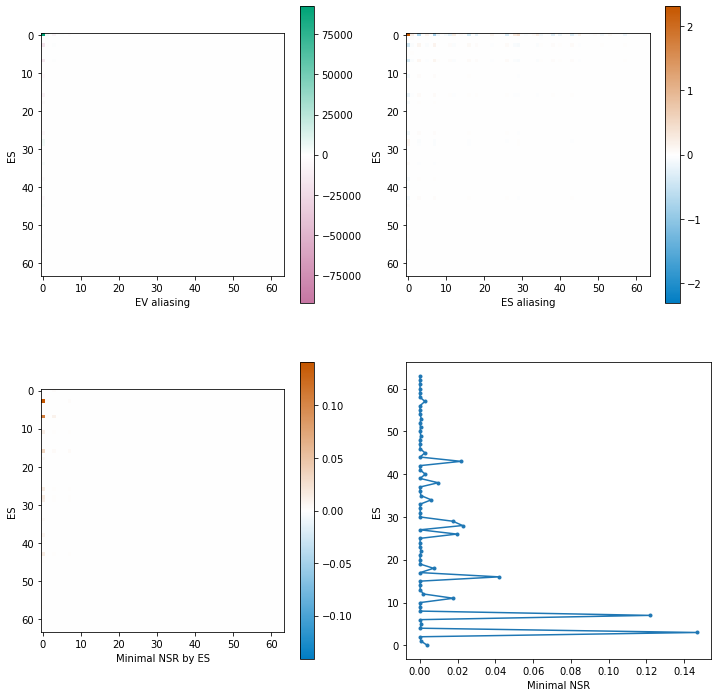

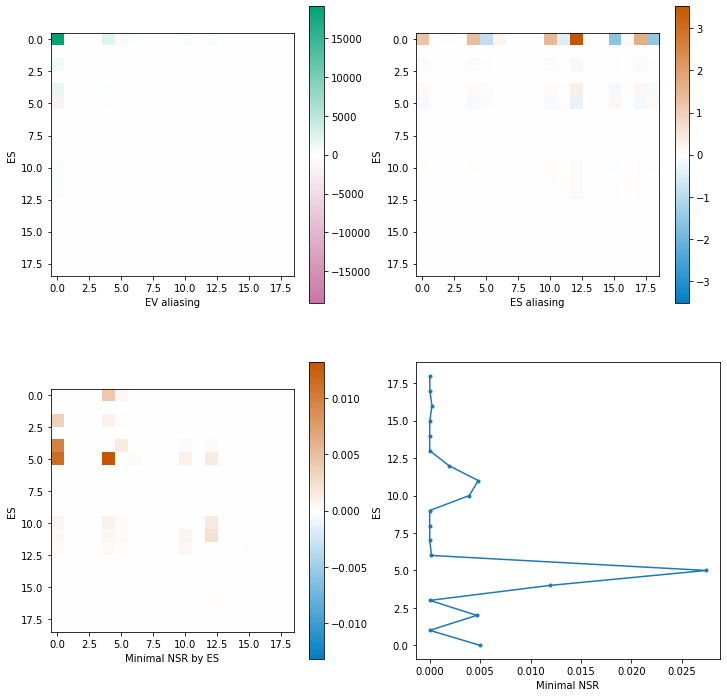

In [34]:
for setup in source_idx:
    print(setup)
    test_aliasing(kernels[f'kcsd_{setup}'], kernels[f'kesi_{setup}'])

In [35]:
def plot_eigenvalues(kcsd):
    n = len(kcsd._pre_kernel)
    KERNEL = kcsd.kernel * n
    
    EIGENVALUES, EIGENVECTORS = np.linalg.eigh(KERNEL)
    EIGENVALUES, EIGENVECTORS = EIGENVALUES[::-1], EIGENVECTORS[:, ::-1]
    
    plt.plot(EIGENVALUES)
    plt.yscale('log')

In [36]:
def plot_eigenvalues_normalized(kcsd):
    KERNEL = kcsd.kernel
    
    EIGENVALUES, EIGENVECTORS = np.linalg.eigh(KERNEL)
    EIGENVALUES, EIGENVECTORS = EIGENVALUES[::-1], EIGENVECTORS[:, ::-1]
    
    plt.plot(EIGENVALUES)
    plt.yscale('log')

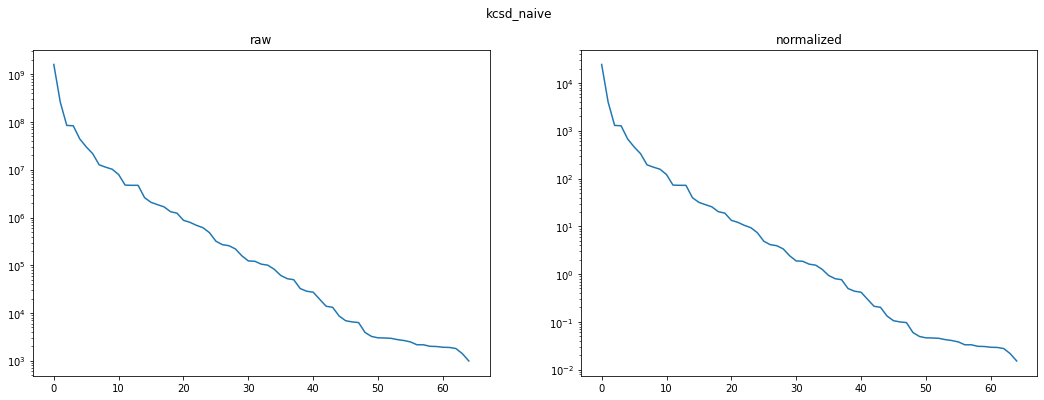

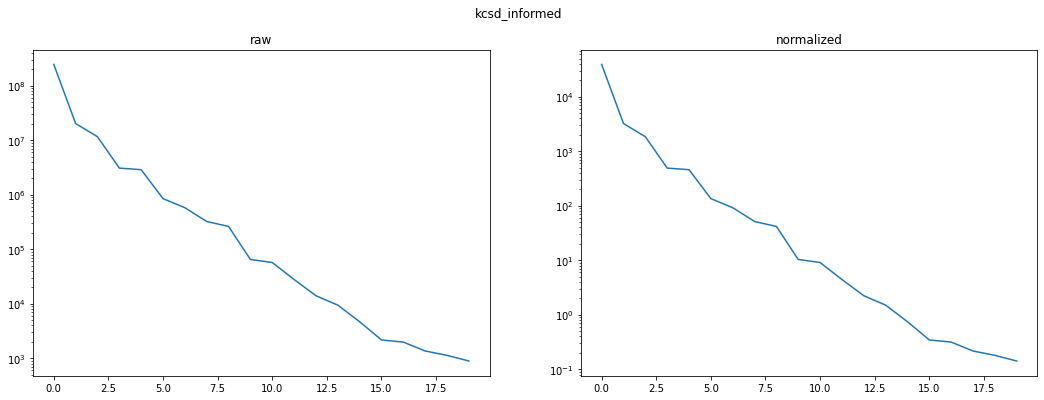

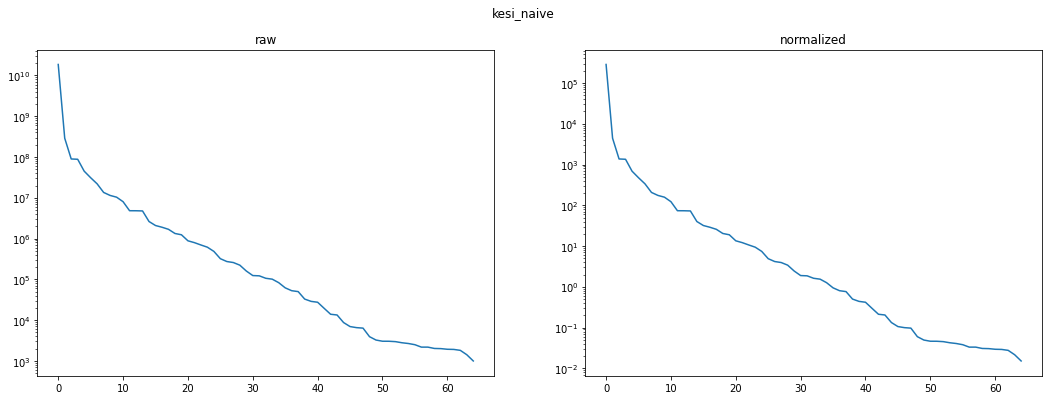

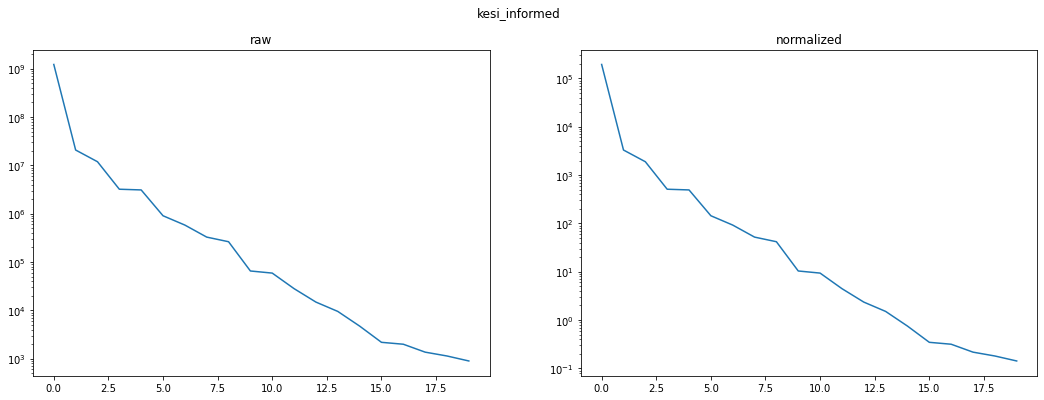

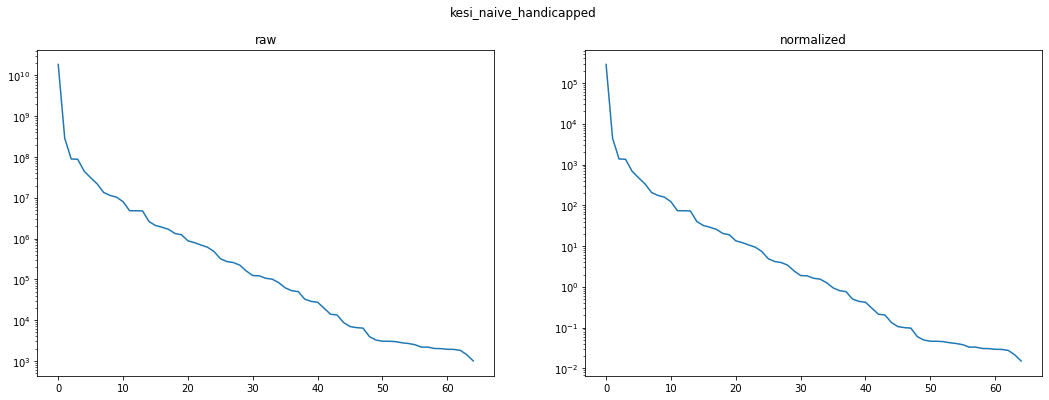

In [37]:
for name, ks in kernels.items():
    plt.figure(figsize=(18, 6))
    plt.suptitle(name)
    plt.subplot(1, 2, 1)
    plt.title('raw')
    plot_eigenvalues(ks)
    
    plt.subplot(1, 2, 2)
    plt.title('normalized')
    plot_eigenvalues_normalized(ks)

In [39]:
_SRC = np.zeros(convolver.shape('SRC'))
_CSD = np.zeros(convolver.shape('CSD'))

for name, ks in kernels.items():
    _n = len(ks._pre_kernel)
    _PHI = ks._pre_kernel * _n
    _KERNEL = ks.kernel * _n

    _EIGENVALUES, _EIGENVECTORS = np.linalg.eigh(_KERNEL)
    _EIGENVALUES, _EIGENVECTORS = _EIGENVALUES[::-1], _EIGENVECTORS[:, ::-1]
    _EIGENSOURCES = np.matmul(_PHI,
                              np.matmul(_EIGENVECTORS,
                                        np.diag(1. / np.sqrt(_EIGENVALUES))))

    for i, _ES in enumerate(_EIGENSOURCES.T):
        print(name, i)
        _SRC[ks.source_indices] = _ES
        _CSD[CSD_IDX] = convolver.base_weights_to_csd(_SRC,
                                                      model_src.csd,
                                                      (ROMBERG_N * 2 - 1,)*3)[CSD_IDX]
        np.savez_compressed(f'{ES_PREFIX}_{name}_ES{i:02d}.npz',
                            X=convolver.CSD_X.flatten(),
                            Y=convolver.CSD_Y.flatten(),
                            Z=convolver.CSD_Z.flatten(),
                            CSD=_CSD,
                            EIGENSOURCE=_ES,
                            EIGENVECTOR=_EIGENVECTORS[:, i],
                            EIGENVALUE=_EIGENVALUES[i],
                            SOURCE_X=convolver.SRC_X.flatten(),
                            SOURCE_Y=convolver.SRC_Y.flatten(),
                            SOURCE_Z=convolver.SRC_Z.flatten(),
                            SOURCE_IDX=ks.source_indices)
    else:
        _SRC[ks.source_indices] = 0

kcsd_naive 0
kcsd_naive 1
kcsd_naive 2
kcsd_naive 3
kcsd_naive 4
kcsd_naive 5
kcsd_naive 6
kcsd_naive 7
kcsd_naive 8
kcsd_naive 9
kcsd_naive 10
kcsd_naive 11
kcsd_naive 12
kcsd_naive 13
kcsd_naive 14
kcsd_naive 15
kcsd_naive 16
kcsd_naive 17
kcsd_naive 18
kcsd_naive 19
kcsd_naive 20
kcsd_naive 21
kcsd_naive 22
kcsd_naive 23
kcsd_naive 24
kcsd_naive 25
kcsd_naive 26
kcsd_naive 27
kcsd_naive 28
kcsd_naive 29
kcsd_naive 30
kcsd_naive 31
kcsd_naive 32
kcsd_naive 33
kcsd_naive 34
kcsd_naive 35
kcsd_naive 36
kcsd_naive 37
kcsd_naive 38
kcsd_naive 39
kcsd_naive 40
kcsd_naive 41
kcsd_naive 42
kcsd_naive 43
kcsd_naive 44
kcsd_naive 45
kcsd_naive 46
kcsd_naive 47
kcsd_naive 48
kcsd_naive 49
kcsd_naive 50
kcsd_naive 51
kcsd_naive 52
kcsd_naive 53
kcsd_naive 54
kcsd_naive 55
kcsd_naive 56
kcsd_naive 57
kcsd_naive 58
kcsd_naive 59
kcsd_naive 60
kcsd_naive 61
kcsd_naive 62
kcsd_naive 63
kcsd_naive 64
kcsd_informed 0
kcsd_informed 1
kcsd_informed 2
kcsd_informed 3
kcsd_informed 4
kcsd_informed 5
kcsd

# FEM images

In [40]:
FEM_CONFIG_GT = f'FEM/fem_configs/paper/{MODEL_NAME}/{MESH_NAME}_{DEGREE}/{CONFIG_NAME}.ini'

In [41]:
import dolfin
import FEM.fem_common as fc
import scipy.interpolate as si

In [42]:
class ForwardModel(object):
    # XXX: duplicated code with FEM classes
    def __init__(self, config):
        self.fm = fc.FunctionManagerINI(config)
        
        self.V = self.fm.function_space
        mesh = self.fm.mesh

        n = self.V.dim()
        d = mesh.geometry().dim()

        self.dof_coords = self.V.tabulate_dof_coordinates()
        self.dof_coords.resize((n, d))
        
        self.csd_f = self.fm.function()
        
        
        mesh_filename = self.fm.getpath('fem', 'mesh')[:-5]
        with dolfin.XDMFFile(mesh_filename + '_subdomains.xdmf') as fh:
            mvc = dolfin.MeshValueCollection("size_t", mesh, 3)
            fh.read(mvc, "subdomains")
            self.subdomains = dolfin.cpp.mesh.MeshFunctionSizet(mesh, mvc)
            self.dx = dolfin.Measure("dx")(subdomain_data=self.subdomains)
            
            
        self.config = configparser.ConfigParser()
        self.config.read(self.fm.getpath('fem', 'config'))

    @property
    def CONDUCTIVITY(self):
        for section in self.config.sections():
            if self._is_conductive_volume(section):
                yield (self.config.getint(section, 'volume'),
                       self.config.getfloat(section, 'conductivity'))

    def _is_conductive_volume(self, section):
        return (self.config.has_option(section, 'volume')
                and self.config.has_option(section, 'conductivity')) 
        
    def __call__(self, csd_interpolator):
        self.csd_f.vector()[:] = csd_interpolator(self.dof_coords)
        
        dirichlet_bc_gt = dolfin.DirichletBC(self.V,
                                     dolfin.Constant(0),
                                     (lambda x, on_boundary:
                                      on_boundary and x[2] < GROUNDED_PLATE_AT))
        test = self.fm.test_function()
        trial = self.fm.trial_function()
        potential = self.fm.function()
        
        
        dx = self.dx
        a = sum(dolfin.Constant(c)
                * dolfin.inner(dolfin.grad(trial),
                               dolfin.grad(test))
                * dx(i)
                for i, c
                in self.CONDUCTIVITY)
        L = self.csd_f * test * dx
        
        b = dolfin.assemble(L)
        A = dolfin.assemble(a)
        dirichlet_bc_gt.apply(A, b)
        
        solver = dolfin.KrylovSolver("cg", "ilu")
        solver.parameters["maximum_iterations"] = 10000
        solver.parameters["absolute_tolerance"] = 1E-8
        # solver.parameters["monitor_convergence"] = True  # Goes to Jupyter server output stream
        solver.solve(A, potential.vector(), b)
        
        return potential

In [43]:
try:
    if FEM_CONFIG_GT != _LAST_FEM_CONFIG_GT:
        raise NameError
except NameError:
    %time fem_gt = ForwardModel(FEM_CONFIG_GT)
    _LAST_FEM_CONFIG_GT = FEM_CONFIG_GT

CPU times: user 26.3 s, sys: 2.72 s, total: 29 s
Wall time: 29.1 s


In [44]:
def forward_eigensources_to_images(fem, ELECTRODES, eigensource_filenames):
    potentials = {ROW.NAME: [] for _, ROW in ELECTRODES.iterrows()}
    
    for filename in eigensource_filenames:
        with np.load(filename) as fh:
            XYZ = [fh[c] for c in 'XYZ']
            CSD = fh['CSD']
        csd_interpolator = si.RegularGridInterpolator(
                                  XYZ,
                                  CSD,
                                  bounds_error=False,
                                  fill_value=0)
        try:
            v = fem(csd_interpolator)
        except RuntimeError:
            v = lambda x, y, z: np.nan
            
        for _, ROW in ELECTRODES.iterrows():
            potentials[ROW.NAME].append(v(ROW.X, ROW.Y, ROW.Z))

    return {name: np.array(a) for name, a in potentials.items()}

In [47]:
for name, _electrodes in electrodes.items():
    eigenimages = forward_eigensources_to_images(fem_gt,
                                       ELECTRODES, 
                                       [f'{ES_PREFIX}_{name}_ES{i:02d}.npz'
                                        for i in range(len(_electrodes))])
    np.savez_compressed(f'{ES_PREFIX}_{name}_ES_IMAGES_AT_ELECTRODES.npz',
                        **eigenimages)

# Reconstructors

In [ ]:
import kesi
import kesi._verbose as verbose

In [ ]:
reconstructor_kesi_informed = verbose.VerboseFFR._CrossKernelReconstructor(
                         kesi._engine._LinearKernelSolver(
                             kesi_kernels_informed.kernel),
                         kesi_kernels_informed.cross_kernel)

In [ ]:
reconstructor_kcsd_informed = verbose.VerboseFFR._CrossKernelReconstructor(
                         kesi._engine._LinearKernelSolver(
                             kcsd_kernels_informed.kernel),
                         kcsd_kernels_informed.cross_kernel)

In [ ]:
reconstructor_kesi_naive = verbose.VerboseFFR._CrossKernelReconstructor(
                         kesi._engine._LinearKernelSolver(
                             kesi_kernels_naive.kernel),
                         kesi_kernels_naive.cross_kernel)

In [ ]:
reconstructor_kcsd_naive = verbose.VerboseFFR._CrossKernelReconstructor(
                         kesi._engine._LinearKernelSolver(
                             kcsd_kernels_naive.kernel),
                         kcsd_kernels_naive.cross_kernel)

In [ ]:
reconstructor = [reconstructor_kcsd_informed,
                 reconstructor_kesi_informed,
                 reconstructor_kcsd_naive,
                 reconstructor_kesi_naive]
reconstructor_name = ['kCSD informed',
                      'kESI informed',
                      'kCSD naive',
                      'kESI naive']

In [ ]:
def wrap_csd(DATA):
    WRAPPED = np.zeros(convolver.shape('CSD'))
    WRAPPED[CSD_ALLOWED] = DATA
    return WRAPPED

In [ ]:
regularization_parameters = np.logspace(-15, 10, 91)

# FEM GT

In [ ]:
EIGENSOURCE_MIXTURE = {
                       7: 1.0,
#                        2: 1.0,
#                        4: 1.0,
#                        3: 0.25,
                       }

In [ ]:
CSD = 0
for es, weight in EIGENSOURCE_MIXTURE.items():
    with np.load(f'{ES_PREFIX}_kCSD_ES{es:02d}.npz',) as fh:
        XYZ = [fh[c] for c in 'XYZ']
        CSD += weight * fh['CSD']

In [ ]:
crude_plot_data(CSD, title='GT')

In [ ]:
import scipy.interpolate as si

In [ ]:
csd_interpolator = si.RegularGridInterpolator([A.flatten() for A in XYZ],
                                              CSD,
                                              bounds_error=False,
                                              fill_value=0)

In [ ]:
FEM_CONFIG_GT = 'FEM/solutions/paper/1SM/finest_3/comb.ini'

In [ ]:
import dolfin
import FEM.fem_common as fc

In [ ]:
class ForwardModel(object):
    # XXX: duplicated code with FEM classes
    def __init__(self, config):
        self.fm = fc.FunctionManagerINI(config)
        
        self.V = self.fm.function_space
        mesh = self.fm.mesh

        n = self.V.dim()
        d = mesh.geometry().dim()

        self.dof_coords = self.V.tabulate_dof_coordinates()
        self.dof_coords.resize((n, d))
        
        self.csd_f = self.fm.function()
        
        
        mesh_filename = self.fm.getpath('fem', 'mesh')[:-5]
        with dolfin.XDMFFile(mesh_filename + '_subdomains.xdmf') as fh:
            mvc = dolfin.MeshValueCollection("size_t", mesh, 3)
            fh.read(mvc, "subdomains")
            self.subdomains = dolfin.cpp.mesh.MeshFunctionSizet(mesh, mvc)
            self.dx = dolfin.Measure("dx")(subdomain_data=self.subdomains)
            
            
        self.config = configparser.ConfigParser()
        self.config.read(self.fm.getpath('fem', 'config'))

    @property
    def CONDUCTIVITY(self):
        for section in self.config.sections():
            if self._is_conductive_volume(section):
                yield (self.config.getint(section, 'volume'),
                       self.config.getfloat(section, 'conductivity'))

    def _is_conductive_volume(self, section):
        return (self.config.has_option(section, 'volume')
                and self.config.has_option(section, 'conductivity')) 
        
    def __call__(self, csd_interpolator):
        self.csd_f.vector()[:] = csd_interpolator(self.dof_coords)
        
        dirichlet_bc_gt = dolfin.DirichletBC(self.V,
                                     dolfin.Constant(0),
                                     (lambda x, on_boundary:
                                      on_boundary and x[2] < GROUNDED_PLATE_AT))
        test = self.fm.test_function()
        trial = self.fm.trial_function()
        potential = self.fm.function()
        
        
        dx = self.dx
        a = sum(dolfin.Constant(c)
                * dolfin.inner(dolfin.grad(trial),
                               dolfin.grad(test))
                * dx(i)
                for i, c
                in self.CONDUCTIVITY)
        L = self.csd_f * test * dx
        
        b = dolfin.assemble(L)
        A = dolfin.assemble(a)
        dirichlet_bc_gt.apply(A, b)
        
        solver = dolfin.KrylovSolver("cg", "ilu")
        solver.parameters["maximum_iterations"] = 10000
        solver.parameters["absolute_tolerance"] = 1E-8
        # solver.parameters["monitor_convergence"] = True  # Goes to Jupyter server output stream
        solver.solve(A, potential.vector(), b)
        
        return potential

In [ ]:
try:
    if FEM_CONFIG_GT != _LAST_FEM_CONFIG_GT:
        raise NameError
except NameError:
    %time fem_gt = ForwardModel(FEM_CONFIG_GT)
    _LAST_FEM_CONFIG_GT = FEM_CONFIG_GT

In [ ]:
%time potential = fem_gt(csd_interpolator)    

In [ ]:
ELE['FEM'] = [potential(x, y, z)
              for x, y, z in zip(ELE.X,
                                 ELE.Y,
                                 ELE.Z)]

# CSD reconstruction

In [ ]:
# POTENTIAL = ELE.FEM

ES = 0
for es, weight in EIGENSOURCE_MIXTURE.items():
    ES += weight * EIGENSOURCES[:, es]

POTENTIAL_FWD = np.matmul(ES, FWD)

In [ ]:
plt.hist(ELE.FEM - POTENTIAL_FWD)

In [ ]:
plt.scatter(ELE.Z, ELE.FEM - POTENTIAL_FWD)

In [ ]:
plt.scatter(ELE.Z,
            (ELE.FEM - POTENTIAL_FWD) / (0.5 * (abs(ELE.FEM) + abs(POTENTIAL_FWD))))

In [ ]:
POTENTIAL = ELE.FEM

In [ ]:
csd_0 = [wrap_csd(rec(POTENTIAL))
          for rec in reconstructor]

In [ ]:
l2_0 = [np.sqrt(np.square(CSD - csd).mean()) / np.sqrt(np.square(CSD).mean())
          for csd in csd_0]

In [ ]:
list(map('{:e}'.format, l2_0))

In [ ]:
amp = abs(CSD).max()

In [ ]:
crude_plot_data(CSD, title='GT')

In [ ]:
for rec, name in zip(csd_0, reconstructor_name):
    crude_plot_data(rec,
                    title=f'{name} no CV',
                    amp=amp)

In [ ]:
error_0 = [rec - CSD for rec in csd_0]
max_err = max(abs(e).max() for e in error_0)

for err, name in zip(error_0, reconstructor_name):
    crude_plot_data(err,
                    title=f'{name} ERR',
                    amp=max_err)

In [ ]:
errors = [common.cv(rec, POTENTIAL, regularization_parameters)
          for rec in reconstructor]

In [ ]:
regularization_parameter = [regularization_parameters[np.argmin(err)]
                            for err in errors]

In [ ]:
for err, rp in zip(errors, regularization_parameter):
    plt.figure()
    plt.xscale('log')
    plt.yscale('log')
    plt.plot(regularization_parameters, err)
    plt.axvline(rp, color='k')

In [ ]:
csd_cv = [wrap_csd(rec(POTENTIAL, regularization_parameter=rp))
          for rec, rp in zip(reconstructor, regularization_parameter)]

In [ ]:
l2_cv = [np.sqrt(np.square(CSD - csd).mean()) / np.sqrt(np.square(CSD).mean())
          for csd in csd_cv]

In [ ]:
list(map('{:e}'.format, l2_cv))

In [ ]:
crude_plot_data(CSD, title='GT')

In [ ]:
for rec, name in zip(csd_cv, reconstructor_name):
    crude_plot_data(rec,
                    title=name,
                    amp=amp)

In [ ]:
error = [rec - CSD for rec in csd_cv]
max_err = max(abs(e).max() for e in error)

for err, name in zip(error, reconstructor_name):
    crude_plot_data(err,
                    title=f'{name} ERR',
                    amp=max_err)

In [ ]:
reconstructor_kcsd_es = verbose.VerboseFFR._CrossKernelReconstructor(
                         kesi._engine._LinearKernelSolver(
                             kcsd_kernels_informed.kernel),
                         np.matmul(EIGENSOURCES.T,
                                   kcsd_kernels_informed._pre_kernel))

In [ ]:
plt.yscale('symlog', linscale=3)
plt.stem(reconstructor_kcsd_es(POTENTIAL))
_X, _Y = zip(*EIGENSOURCE_MIXTURE.items())
plt.scatter(_X, _Y, color=cbf.VERMILION)

In [ ]:
plt.yscale('symlog', linscale=3)
plt.stem(reconstructor_kcsd_es(POTENTIAL,
                               regularization_parameter=regularization_parameter[0]))
_X, _Y = zip(*EIGENSOURCE_MIXTURE.items())
plt.scatter(_X, _Y, color=cbf.VERMILION)

In [ ]:
reconstructor_kesi_es = verbose.VerboseFFR._CrossKernelReconstructor(
                         kesi._engine._LinearKernelSolver(
                             kesi_kernels_informed.kernel),
                         np.matmul(EIGENSOURCES_KESI.T,
                                   kesi_kernels_informed._pre_kernel))

In [ ]:
for i in range(10):
    plt.title(i)
    plt.plot(reconstructor_kesi_es(EIGENVECTORS_KESI[:, i],
                                   regularization_parameter=0))

In [ ]:
plt.plot(reconstructor_kesi_es(POTENTIAL,
                               regularization_parameter=0))
plt.plot(reconstructor_kesi_es(POTENTIAL,
                               regularization_parameter=1))
plt.plot(reconstructor_kesi_es(POTENTIAL,
                               regularization_parameter=10))
plt.plot(reconstructor_kesi_es(POTENTIAL,
                               regularization_parameter=100))
plt.yscale('symlog')

In [ ]:
abs(np.matmul(EIGENSOURCES_KESI.T,
              FWD)
    - np.matmul(np.diag(np.sqrt(EIGENVALUES_KESI)),
                EIGENVECTORS_KESI.T)).max()

In [ ]:
es_fwd = []
es_fwd_ev = []
ev_snr = []
fwd_bwd_es = []
es_snr = []

In [ ]:
assert len(es_fwd) == len(es_snr)

for i in range(len(ev_snr), len(EIGENVALUES_KESI)):
    print(i)
    with np.load(f'{ES_PREFIX}_kESI_ES{i:02d}.npz',) as fh:
        csd_interpolator = si.RegularGridInterpolator([fh[c] for c in 'XYZ'],
                                                      fh['CSD'],
                                                      bounds_error=False,
                                                      fill_value=0)
    v_f = fem_gt(csd_interpolator)
    V_F = [v_f(x, y, z)
           for x, y, z in zip(ELE.X,
                              ELE.Y,
                              ELE.Y)]
    es_fwd.append(V_F)
    EVS = abs(np.matmul(V_F, EIGENVECTORS_KESI))
    es_fwd_ev.append(EVS)
    ev_snr.append(EVS[i] / (EVS.sum() - EVS[i]))
    ESS = EVS / np.sqrt(EIGENVALUES_KESI)
    fwd_bwd_es.append(ESS)
    es_snr.append(ESS[i] / (ESS.sum() - ESS[i]))

In [ ]:
plt.plot(ev_snr, ls='none', marker='o')
plt.yscale('log')
plt.axhline(1, ls=':', color='k')

In [ ]:
plt.plot(es_snr, ls='none', marker='o')
plt.yscale('log')
plt.axhline(1, ls=':', color='k')

In [ ]:
np.dot(EIGENVECTORS[:, 0], EIGENVECTORS_KESI[:, 0])

In [ ]:
np.dot(EIGENSOURCES[:, 0], EIGENSOURCES_KESI[:, 0])

In [ ]:
import json

In [ ]:
json.dumps(list(map(list, ALIASING)))

In [ ]:
%timeit
EIGENSOURCES = np.matmul(PHI,
                         np.matmul(EIGENVECTORS,
                                   np.diag(1. / np.sqrt(EIGENVALUES))))
CORR = FWD - PHI
CORR_POT = np.matmul(EIGENSOURCES.T, CORR)
CORR_EV = np.matmul(CORR_POT, EIGENVECTORS)
CORR_ES = np.matmul(CORR_EV, np.diag(1 / np.sqrt(EIGENVALUES)))

In [ ]:
%timeit
EVS = np.matmul(EIGENVECTORS,
                np.diag(1. / np.sqrt(EIGENVALUES)))
CORR_ES2 = np.matmul(EVS.T,
                     np.matmul(np.matmul(PHI.T, FWD),
                               EVS)) - np.identity(len(EIGENVALUES))

In [ ]:
abs(CORR_ES - CORR_ES2).max()

# mean-centered montage

In [ ]:
m, n = kesi_kernels_informed._pre_kernel.shape
threshold = 1

In [ ]:
TRANS = np.identity(n) - np.ones((n, n)) / n

In [ ]:
FWD = np.matmul(kesi_kernels_informed._pre_kernel * m, TRANS)
PHI = np.matmul(kcsd_kernels_informed._pre_kernel * m, TRANS)
KERNEL = np.matmul(np.matmul(TRANS,
                             kcsd_kernels_informed.kernel * m),
                   TRANS)

In [ ]:
EIGENVALUES, EIGENVECTORS = np.linalg.eigh(KERNEL)
EIGENVALUES, EIGENVECTORS = EIGENVALUES[::-1], EIGENVECTORS[:, ::-1]
LAMBDA = np.sqrt(EIGENVALUES)
EIGENSOURCES = np.matmul(PHI,
                         np.matmul(EIGENVECTORS,
                                   np.diag(1. / LAMBDA)))

CORR = FWD - PHI
CORR_POT = np.matmul(EIGENSOURCES.T, CORR)
CORR_EV = np.matmul(CORR_POT, EIGENVECTORS)

plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)

v_max = abs(CORR_EV).max()
plt.imshow(CORR_EV,
           cmap=cbf.PRGn, vmax=v_max, vmin=-v_max)
plt.ylabel('ES')
plt.xlabel('EV aliasing')
plt.colorbar()

CORR_ES = np.matmul(CORR_EV, np.diag(1 / LAMBDA))

plt.subplot(2, 2, 2)
threshold = abs(CORR_ES).max()
plt.imshow(CORR_ES,
           cmap=cbf.bwr, vmax=threshold, vmin=-threshold)
plt.ylabel('ES')
plt.xlabel('ES aliasing')
plt.colorbar()

EV_I = LAMBDA.reshape(-1, 1)
EV_J = LAMBDA.reshape(1, -1)
A_II = np.diag(CORR_EV).reshape(-1, 1)

NSR_MIN = np.ma.masked_invalid(np.square(CORR_EV / (EV_I + A_II) * np.minimum(EV_I / EV_J, 1)))
np.fill_diagonal(NSR_MIN, 0)

_NSR = NSR_MIN

plt.subplot(2, 2, 3)
threshold_nsr = _NSR.max()

plt.imshow(_NSR,
           cmap=cbf.bwr, vmax=threshold_nsr, vmin=-threshold_nsr)
plt.ylabel('ES')
plt.xlabel('Minimal NSR by ES')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.plot(NSR_MIN.sum(axis=1),
         range(len(_NSR)),
         marker='.')
plt.ylabel('ES')
#     plt.xscale('log')
plt.xlabel('Minimal NSR')

In [ ]:
plt.plot(EIGENVALUES)
plt.yscale('log')

In [ ]:
ELECTRODES.Z.min()

In [ ]:
np.linalg.det(KERNEL), np.linalg.det(kcsd_kernels_informed.kernel * m)

In [ ]:
KERNEL_KESI = np.matmul(np.matmul(TRANS,
                                  kesi_kernels_informed.kernel * m),
                        TRANS)

In [ ]:
np.meshgrid?

In [ ]:
convolver.leadfield_to_base_potentials?

In [ ]:
E_SRC = np.zeros(convolver.shape('SRC'))
try:
    del E_X
except:
    pass

_ELE_Z = np.linspace(0.04, 0.089, 129).reshape(-1, 1)

for i in range(3):
    print(i)
    with np.load(f'{ES_PREFIX}_kESI_ES{i:02d}.npz',) as fh:
        _CSD = fh['CSD']
        _X, _Y, _Z = [fh[c] for c in 'XYZ']
        csd_interpolator = si.RegularGridInterpolator([_X, _Y, _Z],
                                                      _CSD,
                                                      bounds_error=False,
                                                      fill_value=0)
        v_f = fem_gt(csd_interpolator)
        
        try:
            E_X
        except:
            E_X, E_Y, E_Z = np.meshgrid(_X, _Y, _Z,
                                        indexing='ij')
            E_X, E_Y, E_Z = [A[SRC_IDX_INFORMED].reshape(1, -1)
                             for A in [E_X, E_Y, E_Z]]

        _ES = fh['EIGENSOURCE'].reshape(1, -1)
        
        _V_KCSD = (model_src.potential(E_X, E_Y, E_Z - _ELE_Z) * _ES).sum(axis=1)
        _V_KESI = [v_f(0, 0, z) for z in _ELE_Z]
        
    plt.figure()
    plt.title(i)
    plt.plot(_ELE_Z, _V_KCSD, label='kCSD')
    plt.plot(_ELE_Z, _V_KESI, label='kESI')
    plt.legend(loc='best')

In [ ]:
SRC_R_MAX

In [ ]:
_ELE_Z = np.linspace(-0.04, 0.089, 1025)

_X_2 = np.linspace(-SRC_R_MAX, SRC_R_MAX, 257)

try:
    del _CSD_2
except:
    pass

for i in range(1, 40):
    z = 0.089 - 1 * i * SRC_R_MAX
    z_img_flat =  2 * 0.090 - z
    
    # optic stuff
    _f = 0.09 / 2
    _vf = 0.09 - _f
    _ao = 1.
    _fo = z - _f
    _bi = _ao * _vf / _fo  # amp**(1/3)
    _fi = _bi * _vf / _ao
    
    z_img = _f + _fi
    amp_img = _bi ** 3
    print(f'{i}\t{z:.4g}\t{z_img:.4g}\t{amp_img:.4g}')
    
    _src = common.SphericalSplineSourceKCSD(0, 0, z,
                                            [sd, 3 * sd],
                                            [[1],
                                             [0,
                                              2.25 / sd,
                                              -1.5 / sd ** 2,
                                              0.25 / sd ** 3]],
                                            conductivity)
    _src_img = common.SphericalSplineSourceKCSD(0, 0, z_img,
                                            [sd, 3 * sd],
                                            [[1],
                                             [0,
                                              2.25 / sd,
                                              -1.5 / sd ** 2,
                                              0.25 / sd ** 3]],
                                            conductivity)
    _src_img_flat = common.SphericalSplineSourceKCSD(0, 0, z_img_flat,
                                            [sd, 3 * sd],
                                            [[1],
                                             [0,
                                              2.25 / sd,
                                              -1.5 / sd ** 2,
                                              0.25 / sd ** 3]],
                                            conductivity)

    
    _V_KCSD = _src.potential(0, 0, _ELE_Z)
    _V_IMG = _V_KCSD + amp_img * _src_img.potential(0, 0, _ELE_Z)
    _V_IMG_FLAT = _V_KCSD + _src_img_flat.potential(0, 0, _ELE_Z)

    try:
        _CSD_2
    except:
        _CSD_2 = _src.csd(_X_2.reshape(-1, 1, 1),
                          _X_2.reshape(1, -1, 1),
                          z + _X_2.reshape(1, 1, -1))
        
    
    csd_interpolator = si.RegularGridInterpolator([_X_2, _X_2, _X_2 + z],
                                                  _CSD_2,
                                                  bounds_error=False,
                                                  fill_value=0)
    v_f = fem_gt(csd_interpolator)
    _V_KESI = np.array([v_f(0, 0, z) for z in _ELE_Z])
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title(z)
    plt.plot(_ELE_Z, _V_KCSD, label='kCSD', ls='-')
    plt.plot(_ELE_Z, _V_KESI, label='FEM', ls='--')
    plt.plot(_ELE_Z, _V_IMG, label='$IMG_{almost}$', ls=':')
    plt.plot(_ELE_Z, _V_IMG_FLAT, label='$IMG_{flat}$', ls='-.')
    plt.legend(loc='best')
    
    plt.subplot(1, 2, 2)
    plt.title('ERR to FEM')
    plt.plot(_ELE_Z, _V_KCSD - _V_KESI, label='kCSD', ls='-')
    plt.plot(_ELE_Z, _V_IMG - _V_KESI, label='$IMG_{almost}$', ls='--')
    plt.plot(_ELE_Z, _V_IMG_FLAT - _V_KESI, label='$IMG_{flat}$', ls=':')
    plt.legend(loc='best')


In [ ]:
_ELE_Z = np.linspace(-0.04, 0.089, 1025)

_X_2 = np.linspace(-SRC_R_MAX, SRC_R_MAX, 257)

try:
    del _CSD_2
except:
    pass

for i in range(1, 40):
    z = 0.089 - 1 * i * SRC_R_MAX
    z_img_flat =  2 * 0.090 - z
    
    # optic stuff
    _f = 0.09 / 2
    _vf = 0.09 - _f
    _ao = 1.
    _fo = z - _f
    _bi = _ao * _vf / _fo  # amp**(1/3)
    _fi = _bi * _vf / _ao
    
    z_img = _f + _fi
    amp_img = _bi ** 3
    print(f'{i}\t{z:.4g}\t{z_img:.4g}\t{amp_img:.4g}')
    
    _src = common.SphericalSplineSourceKCSD(0, 0, z,
                                            [sd, 3 * sd],
                                            [[1],
                                             [0,
                                              2.25 / sd,
                                              -1.5 / sd ** 2,
                                              0.25 / sd ** 3]],
                                            conductivity)
    _src_img = common.SphericalSplineSourceKCSD(0, 0, z_img,
                                            [sd, 3 * sd],
                                            [[1],
                                             [0,
                                              2.25 / sd,
                                              -1.5 / sd ** 2,
                                              0.25 / sd ** 3]],
                                            conductivity)
    _src_img_flat = common.SphericalSplineSourceKCSD(0, 0, z_img_flat,
                                            [sd, 3 * sd],
                                            [[1],
                                             [0,
                                              2.25 / sd,
                                              -1.5 / sd ** 2,
                                              0.25 / sd ** 3]],
                                            conductivity)

    
    _V_KCSD = _src.potential(0, 0, _ELE_Z)
    _V_IMG = _V_KCSD + amp_img * _src_img.potential(0, 0, _ELE_Z)
    _V_IMG_FLAT = _V_KCSD + _src_img_flat.potential(0, 0, _ELE_Z)

    try:
        _CSD_2
    except:
        _CSD_2 = _src.csd(_X_2.reshape(-1, 1, 1),
                          _X_2.reshape(1, -1, 1),
                          z + _X_2.reshape(1, 1, -1))
        
    
    csd_interpolator = si.RegularGridInterpolator([_X_2, _X_2, _X_2 + z],
                                                  _CSD_2,
                                                  bounds_error=False,
                                                  fill_value=0)
    v_f = fem_gt(csd_interpolator)
    _V_KESI = np.array([v_f(0, 0, z) for z in _ELE_Z])
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title(z)
    plt.plot(_ELE_Z, _V_KCSD, label='kCSD', ls='-')
    plt.plot(_ELE_Z, _V_KESI, label='FEM', ls='--')
    plt.plot(_ELE_Z, _V_IMG, label='$IMG_{almost}$', ls=':')
    plt.plot(_ELE_Z, _V_IMG_FLAT, label='$IMG_{flat}$', ls='-.')
    plt.legend(loc='best')
    
    plt.subplot(1, 2, 2)
    plt.title('ERR to FEM')
    plt.plot(_ELE_Z, _V_KCSD - _V_KESI, label='kCSD', ls='-')
    plt.plot(_ELE_Z, _V_IMG - _V_KESI, label='$IMG_{almost}$', ls='--')
    plt.plot(_ELE_Z, _V_IMG_FLAT - _V_KESI, label='$IMG_{flat}$', ls=':')
    plt.legend(loc='best')


Paraxial approximation should work well for depths 59-74 mm.

In [ ]:
electrode._X

In [55]:
len(kernels['kesi_informed']._pre_kernel)

6292

In [56]:
convolver.shape('SRC')

(85, 39, 185)